This "flow downslope" example involves four sub-directories, `layer`, `rho`, `sigma` and `z`, in which the model is running in one of four coordinate configurations. To  use this notebook it is assumed you have run each of those experiments in place and have kept the output generated in default configuration.

## CAVEAT: This is a tutorial of how to make vertical section plots which also illustrates some poor ways to plot data for comparison. Read through to the end.

We will use matplotlib. The line `%pylab inline` loads all the necessary packages, including `numpy` and causes images to appear in the page. We will use `scipy`'s netcdf package to read MOM6 output. Note that this only works if MOM6 is compiled with `NETCDF=3`.

In [1]:
%pylab inline
import scipy.io.netcdf

Populating the interactive namespace from numpy and matplotlib


### Accessing MOM6 output

Let's open some MOM6 output files and see what variables we diagnosed. We'll use `scipy.io.netcdf_file` but you could also use the `netCDF4` package and `netCDF4.Dataset` with the same syntax. Both functions return objects with members (functions or dictionaries) such as `.variables`:

In [2]:
layer_file = scipy.io.netcdf_file('layer/prog.nc')
rho_file = scipy.io.netcdf_file('rho/prog.nc')
sigma_file = scipy.io.netcdf_file('sigma/prog.nc')
z_file = scipy.io.netcdf_file('z/prog.nc')
for v in layer_file.variables:
    print(v,layer_file.variables[v].shape,layer_file.variables[v].long_name)

zi (41,) b'Interface Target Potential Density'
zl (40,) b'Layer Target Potential Density'
u (12, 40, 4, 80) b'Zonal velocity'
h (12, 40, 4, 80) b'Layer Thickness'
Time (12,) b'Time'
v (12, 40, 4, 80) b'Meridional velocity'
yq (4,) b'q point nominal latitude'
e (12, 41, 4, 80) b'Interface Height Relative to Mean Sea Level'
xq (80,) b'q point nominal longitude'
temp (12, 40, 4, 80) b'Potential Temperature'
yh (4,) b'h point nominal latitude'
salt (12, 40, 4, 80) b'Salinity'
xh (80,) b'h point nominal longitude'


The above output is the result of this `diag_table`:

In [3]:
!head -15 layer/diag_table

"MOM resting experiment"
1 1 1 0 0 0
"prog",     1 ,"hours",1,"days","Time"

#This is the field section of the diag_table.

# Prognostic Ocean fields:
#=========================

"ocean_model","u","u","prog","all",.false.,"none",2
"ocean_model","v","v","prog","all",.false.,"none",2
"ocean_model","h","h","prog","all",.false.,"none",1
"ocean_model","e","e","prog","all",.false.,"none",2
"ocean_model","temp","temp","prog","all",.false.,"none",2
"ocean_model","salt","salt","prog","all",.false.,"none",2


We actually only asked for "e", "h", "u", "v", "salt" and "temp" in the `diag_table`. The other variables (such as "xh", "yq", etc) are all 1-dimensional "axis" variables assoicated with netcdf dimensions. This is a consequence of the CF convention used in MOM6 output.

### Coordinates to use for plotting

Because MOM6 uses curvilinear coordinates in the horizontal, the axis variables for the horizontal dimensions are not always useful. 

This particular experiment *is* in cartesian coordinates so we *can* use the variables "xh" for the h-point locations and "xq" for the u-points. In this instance we can read the 1D axis variables to use as coordiantes:

In [4]:
# Use the CF dimension-variable as the horizontal coordinate
xh = layer_file.variables['xh'][:] # This is the coordinate of the cell centers (h-points in 1D)
xq = layer_file.variables['xq'][:] # This is the coordinate of the cell corners (u-points in 1D)
xq = numpy.concatenate(([2*xq[0]-xq[1]],xq)) # Inserts left most edge of domain in to u-point coordinates

In addition to output requested in the `diag_table`, MOM6 normally writes a files with static coordinates and metrics to `ocean_geometry.nc`:

In [5]:
geom_file = scipy.io.netcdf_file('layer/ocean_geometry.nc')
for v in geom_file.variables:
    print(v,geom_file.variables[v].shape,geom_file.variables[v].long_name)

dxCvo (4, 80) b'Open zonal grid spacing at v points'
dyCv (4, 80) b'Meridional grid spacing at v points'
dxCu (4, 80) b'Zonal grid spacing at u points'
dxCv (4, 80) b'Zonal grid spacing at v points'
lonq (80,) b'Longitude'
geolonb (4, 80) b'longitude at corner (Bu) points'
Aq (4, 80) b'Area of q cells'
wet (4, 80) b'land or ocean?'
geolatb (4, 80) b'latitude at corner (Bu) points'
geolon (4, 80) b'longitude at tracer (T) points'
dyCu (4, 80) b'Meridional grid spacing at u points'
latq (4,) b'Latitude'
dyBu (4, 80) b'Meridional grid spacing at q points'
dyCuo (4, 80) b'Open meridional grid spacing at u points'
dyT (4, 80) b'Meridional grid spacing at h points'
f (4, 80) b'Coriolis Parameter'
geolat (4, 80) b'latitude at tracer (T) points'
D (4, 80) b'Basin Depth'
dxT (4, 80) b'Zonal grid spacing at h points'
lonh (80,) b'Longitude'
lath (4,) b'Latitude'
dxBu (4, 80) b'Zonal grid spacing at q points'
Ah (4, 80) b'Area of h cells'


Here, you'll see some 2D coordinate variables such as `geolon` and `geolonb` that facilitates plotting when the coordinates are curvilinear. We can check that the data is cartesion and matches the CF dimensions-variable we read earlier with

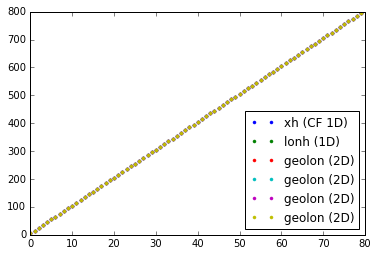

In [6]:
plt.plot( xh, '.', label='xh (CF 1D)');
plt.plot( geom_file.variables['lonh'][:].T, '.', label='lonh (1D)');
plt.plot( geom_file.variables['geolon'][:].T, '.', label='geolon (2D)');
plt.legend(loc='lower right');

The above plot just confirms that we have the same values in numerous forms of the horizontal coordinates (for this experiment). In general, to make plan view plots for a 3D configuration you will always what to use the 2D coordinate data such as that in `ocean_geometry.nc` but here we will be making vertical section plots which only require the 1D form of horizontal coordinates.

### Reading bottom depth from `ocean_geometry.nc`

Now let's plot the topography, which is contained in the variable `D` of `ocean_geometry.nc`.

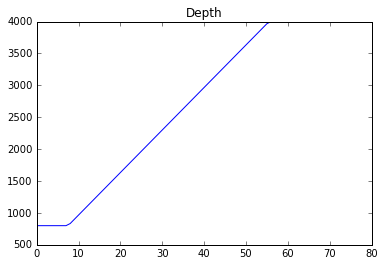

In [7]:
plt.plot( geom_file.variables['D'][0,:]); plt.title('Depth');

"Depth" is a positive quantity for the ocean; the bottom is at height $z=-D(x,y)$. The topography visualized for this experiment is a flat shallow shelf on the left, a flat deep ocean on the right, and a linear slope in between.

The "flow downslope" example is ostensibly a 2D configuration in x-z. One would expect the y-dimension to be equal to 1 but it is instead equal to 4. Each of the 4 j-slices of an array will contain the exact same data. This is because a dimension in MOM6 can not be reduced to below the width of a parallelization halo width, which is typically equal to 4 or more.

This quickly illustrates that the mdoel state is identical along the j-axis:

In [8]:
print("mean square |h(j=0)-h(j=3)|^2 =",
      (( layer_file.variables['h'][-1,:,0,:]-layer_file.variables['h'][-1,:,3,:] )**2).sum() )

mean square |h(j=0)-h(j=3)|^2 = 0.0


So from here on, we will use j=0 in all plots.

### Exploring vertically distributed model output

Now let's look at some model data in multiple coordinate modes. We opened the output files above. The python variable `layer_file` is a handle to the netcdf file `layer/prog.nc` which is output using the traditional isopycnal (or stacked shallow water) mode of MOM6. The other models in this experiment are all ALE-mode emulating the z*-coordinate (python variable `z_file` for `z/prog.nc`), terrain-following sigma-coordinate (`sigma_file` for `sigma/prog.nc`), and continuous isopycnal coorindate (`rho_file` for `rho/prog.nc`).

The diagnosed variables in each of these modes was the same. However, some axis data changes meaning. For example, the vertical coordinate in layer mode is a "target density":

In [9]:
print( layer_file.variables['zl'].long_name, layer_file.variables['zl'].units, layer_file.variables['zl'][:] )

b'Layer Target Potential Density' b'kg m-3' [ 1035.0125  1035.0375  1035.0625  1035.0875  1035.1125  1035.1375
  1035.1625  1035.1875  1035.2125  1035.2375  1035.2625  1035.2875
  1035.3125  1035.3375  1035.3625  1035.3875  1035.4125  1035.4375
  1035.4625  1035.4875  1035.5125  1035.5375  1035.5625  1035.5875
  1035.6125  1035.6375  1035.6625  1035.6875  1035.7125  1035.7375
  1035.7625  1035.7875  1035.8125  1035.8375  1035.8625  1035.8875
  1035.9125  1035.9375  1035.9625  1035.9875]


When the model is in ALE mode emulating a z* coordinate, then the vertical coordinate is height (although we report notional depth to aid ferret with plotting):

In [10]:
print( z_file.variables['zl'].long_name, z_file.variables['zl'].units, z_file.variables['zl'][:] )

b'Layer pseudo-depth, -z*' b'meter' [   50.   150.   250.   350.   450.   550.   650.   750.   850.   950.
  1050.  1150.  1250.  1350.  1450.  1550.  1650.  1750.  1850.  1950.
  2050.  2150.  2250.  2350.  2450.  2550.  2650.  2750.  2850.  2950.
  3050.  3150.  3250.  3350.  3450.  3550.  3650.  3750.  3850.  3950.]


Let's look at salinity in the first record written by the model in each of these four coordinates. We'll plot the raw data without coordinates, i.e. in index space.

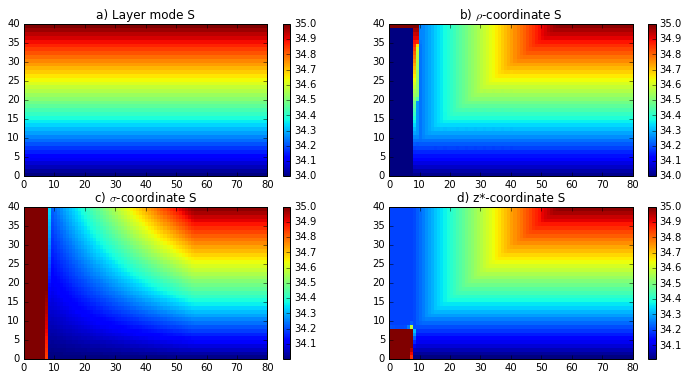

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(221);
plt.pcolormesh( layer_file.variables['salt'][0,:,0,:] ); plt.colorbar(); plt.title('a) Layer mode S');
plt.subplot(222);
plt.pcolormesh( rho_file.variables['salt'][0,:,0,:] ); plt.colorbar(); plt.title(r'b) $\rho$-coordinate S');
plt.subplot(223);
plt.pcolormesh( sigma_file.variables['salt'][0,:,0,:] ); plt.colorbar(); plt.title(r'c) $\sigma$-coordinate S');
plt.subplot(224);
plt.pcolormesh( z_file.variables['salt'][0,:,0,:] ); plt.colorbar(); plt.title('d) z*-coordinate S');

There is no topography apparent in the plots and the salinity structure is hard to make sense of! In layer mode there is not even any horizontal structure. This is because in layer mode density is homogenous along a layer whereas in ALE mode density (in this case salinity) is allowed to vary along layers.

Plotting output from any model in index-space ignores the coordinates which determines where the data is physically located. The apparent absence of topography is a symptom of this. In MOM6, layers always contain data but layers have variable thickness which can even vanish. This is what thickness looks like for the above salinity panels:

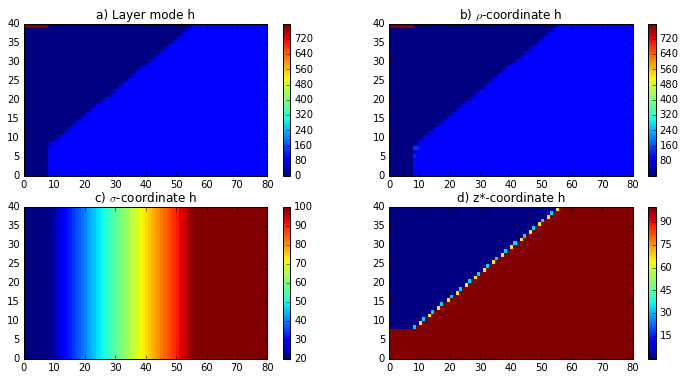

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(221);
plt.pcolormesh( layer_file.variables['h'][0,:,0,:] ); plt.colorbar(); plt.title('a) Layer mode h');
plt.subplot(222);
plt.pcolormesh( rho_file.variables['h'][0,:,0,:] ); plt.colorbar(); plt.title(r'b) $\rho$-coordinate h');
plt.subplot(223);
plt.pcolormesh( sigma_file.variables['h'][0,:,0,:] ); plt.colorbar(); plt.title(r'c) $\sigma$-coordinate h');
plt.subplot(224);
plt.pcolormesh( z_file.variables['h'][0,:,0,:] ); plt.colorbar(); plt.title('d) z*-coordinate h');

The simplest distribution to explain is the terrain-following $\sigma$-coordinate in which the layers are uniformly distributed in each column to fit the topography. Thus $h$ has no vertical structure in panel c. 

For the other panels it is important to remember the the k-index increase downward in the model; k=1 (fortran convention) or k=0 (python convention) is at the surface. Panel d has a region of uniform resolution (~100m) at low k which transitions to vanished thickness (~0) at some value of k in each column. You can sort of see the topography (blue region) upside down. Panels a and b look similar and have a lot of vanished regions with even surface layers being vanished.

Before making sense of these thickness distributions, let's check that the total thickness in each column looks like the topography:

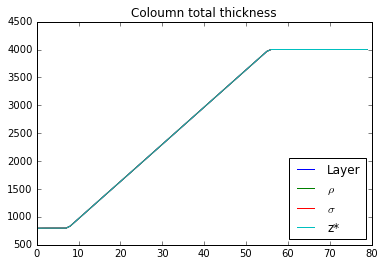

In [13]:
plt.plot( layer_file.variables['h'][0,:,0,:].sum(axis=0), label='Layer');
plt.plot( rho_file.variables['h'][0,:,0,:].sum(axis=0), label=r'$\rho$');
plt.plot( sigma_file.variables['h'][0,:,0,:].sum(axis=0), label=r'$\sigma$');
plt.plot( z_file.variables['h'][0,:,0,:].sum(axis=0), label='z*');
plt.legend(loc='lower right'); plt.title('Coloumn total thickness');

We see that although the thickness distributions are quite different between each model, the total thickness of each column reflects the topography we plotted earlier based on the `ocean_geometry.nc` file.

The layer thickness almost provides enough information to calculate the actual position of quantities with which we could then make plots. The missing information is the absolute position of the top or bottom.

Interfaces delineate, or bound, layers. The thickness of a layer, $h_{i,j,k}$, is related to the absolute position of the interface above, $z_{i,j,k-\frac{1}{2}}$, and below, $z_{i,j,k+\frac{1}{2}}$ by
$$
h_{i,j,k} = z_{i,j,k-\frac{1}{2}} - z_{i,j,k+\frac{1}{2}} \;\;\; \forall \; k=1,2,\ldots,nk
$$

where, by convention, integer-valued indices indicate layer-centered quantities and half-valued indices indicate interface-located quantities. Interface and and layer quantities are thus staggered in the vertical.

The diagnostic variable `e` is the absolute vertical position of model interfaces. Because half-integer indices are not meaningful in most copmuter languages, there is a offset convention as follows.

In FORTRAN:
$$
h(i,j,k) = e(i,j,k) - e(i,j,k+1) \;\;\; \forall \; k=1,2,\ldots,nk
$$

where arrays indices normally start at 1.

In python
$$
h[k,j,i] = e[k,j,i] - e[k+1,j,i] \;\;\; \forall \; k=0,1,\ldots,nk-1
$$

where array indices start at 0. We have also indicated the [k,j,i] order of indices that arises from reading data from an model-generated netcdf file.

Let's look at where the interfaces are by plotting a line for each interface (note the use of the transpose `.T` operator to get these lines plotted in the right direction):

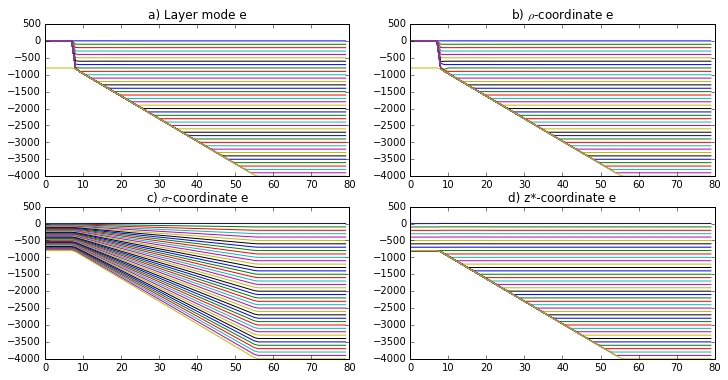

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(221); plt.plot( layer_file.variables['e'][0,:,0,:].T); plt.title('a) Layer mode e');
plt.subplot(222); plt.plot( rho_file.variables['e'][0,:,0,:].T); plt.title(r'b) $\rho$-coordinate e');
plt.subplot(223); plt.plot( sigma_file.variables['e'][0,:,0,:].T); plt.title(r'c) $\sigma$-coordinate e');
plt.subplot(224); plt.plot( z_file.variables['e'][0,:,0,:].T); plt.title('d) z*-coordinate e');

You can now begin to discern the nature of the coordinates in each mode. If we zoom in on the shelf-break region we will be able to more clearly see what each coordinate mode is doing.

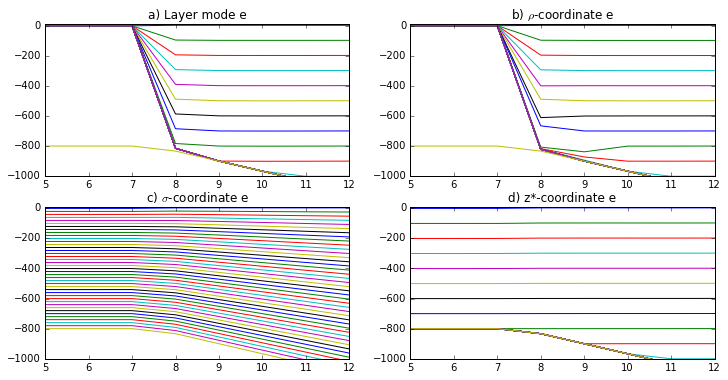

In [15]:
plt.figure(figsize=(12,6))
xl=5,12; yl=-1000,10
plt.subplot(221); plt.plot( layer_file.variables['e'][0,:,0,:].T); plt.xlim(xl); plt.ylim(yl); plt.title('a) Layer mode e');
plt.subplot(222); plt.plot( rho_file.variables['e'][0,:,0,:].T); plt.xlim(xl); plt.ylim(yl); plt.title(r'b) $\rho$-coordinate e');
plt.subplot(223); plt.plot( sigma_file.variables['e'][0,:,0,:].T); plt.xlim(xl); plt.ylim(yl); plt.title(r'c) $\sigma$-coordinate e');
plt.subplot(224); plt.plot( z_file.variables['e'][0,:,0,:].T); plt.xlim(xl); plt.ylim(yl); plt.title('d) z*-coordinate e');

The $\sigma$-coordinate (c) always has `nk` layers with finite thickness (uniformly distributed) in each column. The $z$*-coordinate model (d) seems to have a variable number of layers but in fact the layers thicknesses vanish wherever the layer would be below the topography. The isopycnal coordinates, both in layer-mode (a) and ALE-mode (b), have on one thick layer on the shelf and fewer finite-thickness layers off-shelf than the other models. In these cases, there are vanished layers at both the top and bottom of the column.

So now we know the location of the interfaces we can presume the center of the layer is in between at $(e[k,j,i]+e[k+1,j,i])/2$. Let's use `contourf` to shade salinity at the layer centers. Note how we have to create a 2D "x" coordinate to pass to `contourf` since `contourf` expects both coordinate arrays to be 2D if either one of them is 2D. We do this by using an expression `x=xh+0*z` which uses `numpy`'s "broadcasting" feature (see http://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html for explanation of rules). We will also plot the interface positions on top of the shaded contours:

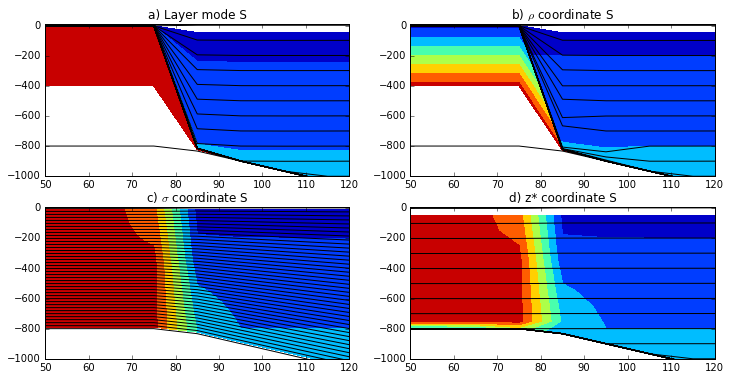

In [16]:
plt.figure(figsize=(12,6))
xxl=50,120 # This is the zoomed-in region around the shelf break in model coordinates
plt.subplot(221)
z = ( layer_file.variables['e'][0,:-1,0,:] + layer_file.variables['e'][0,1:,0,:] ) / 2
x = xh + 0*z
plt.contourf( x, z, layer_file.variables['salt'][0,:,0,:]); plt.xlim(xxl); plt.ylim(yl); plt.title('a) Layer mode S');
plt.plot( xh, layer_file.variables['e'][0,:,0,:].T, 'k');
plt.subplot(222)
z = ( rho_file.variables['e'][0,:-1,0,:] + rho_file.variables['e'][0,1:,0,:] ) / 2
plt.contourf( x, z, rho_file.variables['salt'][0,:,0,:]); plt.xlim(xxl); plt.ylim(yl); plt.title(r'b) $\rho$ coordinate S');
plt.plot( xh, rho_file.variables['e'][0,:,0,:].T, 'k');
plt.subplot(223)
z = ( sigma_file.variables['e'][0,:-1,0,:] + sigma_file.variables['e'][0,1:,0,:] ) / 2
plt.contourf( x, z, sigma_file.variables['salt'][0,:,0,:]); plt.xlim(xxl); plt.ylim(yl); plt.title(r'c) $\sigma$ coordinate S');
plt.plot( xh, sigma_file.variables['e'][0,:,0,:].T, 'k');
plt.subplot(224)
z = ( z_file.variables['e'][0,:-1,0,:] + z_file.variables['e'][0,1:,0,:] ) / 2
plt.contourf( x, z, z_file.variables['salt'][0,:,0,:]); plt.xlim(xxl); plt.ylim(yl); plt.title('d) z* coordinate S');
plt.plot( xh, z_file.variables['e'][0,:,0,:].T, 'k');

The above looks closer to what one imagines things look like but **there are some very big problems with the above plots**.

1) The apparent topography (white regions at bottom of plots) is quite different between the panels. This happens because `contourf` only shades between cell centers and so only half of the edge cells are plotted. `contourf` does not extrapolate beyond the coordinate provided for the data location. We loose a half cell of shading at the top and bottom of the column and also at the left and right of the plot. In the isopycnal-like coordinates, the bottom layer is thick and so we loose a lot.

2) The shading within layers and between columns is interpolated which is introducing interior features and gradients which should not be there. The overlaid interface positions make this apparent for the layer mode for which salinity is absolutely constant along a layer (recall first plot of salinity).

To get the plot we want we essentially need to insert a layer of extra data at the top and bottom of the model and an extra column at both ends. To illustrate lets see how one might do this first for the "layer" output. We'll define a little function to help:

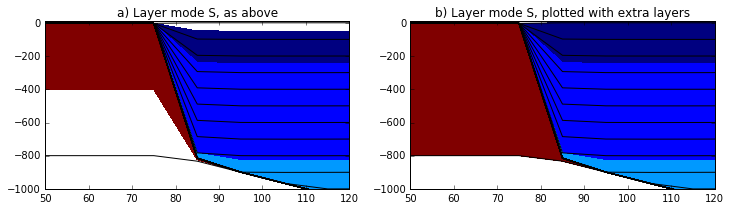

In [17]:
def fix_contourf(nc_object, record, xh, variable='salt', clim=None, xl=None, yl=None, plot_grid=True):
    e = nc_object.variables['e'][record,:,0,:] # Interface positions
    z = ( e[:-1,:] + e[1:,:] ) / 2 # Layer centers
    S = nc_object.variables[variable][record,:,0,:] # Model output
    z = numpy.vstack( ( e[0,:], z, e[-1,:] ) ) # Add a layer at top and bottom
    S = numpy.vstack( ( S[0,:], S, S[-1,:] ) ) # Add layer data from top and bottom
    x = xh + 0*z
    plt.contourf( x, z, S );
    if clim is not None: plt.clim(clim);
    if plot_grid: plt.plot( xh, e.T, 'k');
    if xl is not None: plt.xlim(xl);
    if yl is not None: plt.ylim(yl);

plt.figure(figsize=(12,3))
# Same plot as above
plt.subplot(121)
z = ( layer_file.variables['e'][0,:-1,0,:] + layer_file.variables['e'][0,1:,0,:] ) / 2
x = xh + 0*z
plt.contourf( x, z, layer_file.variables['salt'][0,:,0,:]); plt.xlim(xxl); plt.ylim(yl);
plt.title('a) Layer mode S, as above');
plt.plot( xh, layer_file.variables['e'][0,:,0,:].T, 'k');
plt.clim(34,35)
# Now with an extra layer above and below
plt.subplot(122)
fix_contourf(layer_file, 0, xh, xl=xxl, yl=yl, clim=(34,35)); plt.title('b) Layer mode S, plotted with extra layers');

So not the data appears to be plotted from the surface down to the topography. Using this approach for all the coordinates:

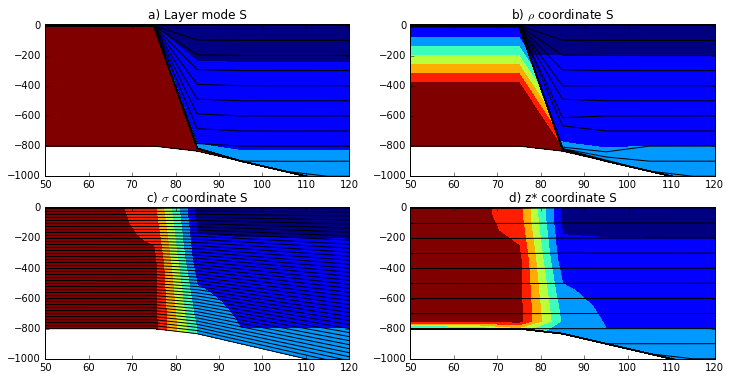

In [18]:
plt.figure(figsize=(12,6))
xxl=50,120 # This is the zoomed-in region around the shelf break in model coordinates
plt.subplot(221); fix_contourf(layer_file, 0, xh, xl=xxl, yl=yl, clim=(34,35)); plt.title('a) Layer mode S')
plt.subplot(222); fix_contourf(rho_file, 0, xh, xl=xxl, yl=yl, clim=(34,35)); plt.title(r'b) $\rho$ coordinate S');
plt.subplot(223); fix_contourf(sigma_file, 0, xh, xl=xxl, yl=yl, clim=(34,35)); plt.title(r'c) $\sigma$ coordinate S');
plt.subplot(224); fix_contourf(z_file, 0, xh, xl=xxl, yl=yl, clim=(34,35)); plt.title('d) z* coordinate S');

A remaining issue is why does there appear to be a salinity inversion in the z*-coordinate model. Techinically there is (see salinity plots in i,k-space) but the layers are vanished so we should not be seeing them. This is because `contourf` is interpolating between thick and vanished layers. The bottom-line is that `contourf` is assuming the data is smooth and interpretting data inconsistent with the model formulation which considers the data to be piecewise.

### Use `pcolormesh()` to visualize

The most consistent tool for visualizing piecewise data is `pcolormesh`. An important distinction between `contourf` and `pcolormesh` is that the latter takes the coordinates of the corners of cells when shading cell-centered values. Recall we loaded the coordinate `yq` and inserted an extra value on the left edge - we'll use that for the horizontal coordinate of cell edges. We will horizontally average to get an approximate position for the cell corner heights:

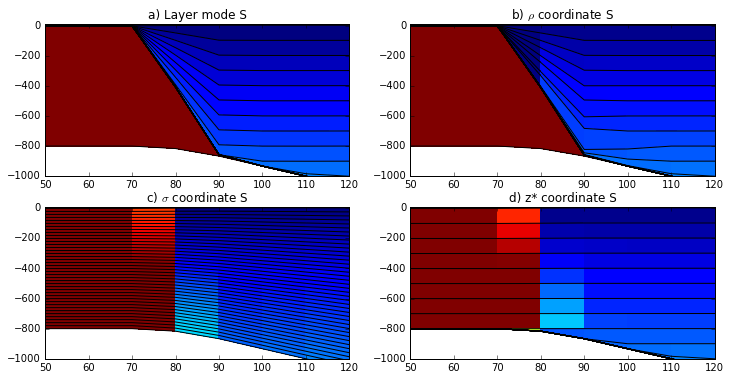

In [19]:
def plot_with_pcolormesh(nc_object, record, xq, variable='salt', clim=None, xl=None, yl=None, plot_grid=True):
    e = nc_object.variables['e'][record,:,0,:] # Interface positions for h-columns
    ea = numpy.vstack( ( e[:,0].T, (e[:,:-1].T+e[:,1:].T)/2, e[:,-1].T ) ).T # Interface positions averaged to u-columns
    plt.pcolormesh( xq+0*ea, ea, nc_object.variables[variable][record,:,0,:] )
    if clim is not None: plt.clim(clim);
    if plot_grid: plt.plot( xq, ea.T, 'k');
    if xl is not None: plt.xlim(xl);
    if yl is not None: plt.ylim(yl);

plt.figure(figsize=(12,6))
xxl=50,120 # This is the zoomed-in region around the shelf break in model coordinates
plt.subplot(221); plot_with_pcolormesh(layer_file, 0, xq, xl=xxl, yl=yl, clim=(34,35)); plt.title('a) Layer mode S')
plt.subplot(222); plot_with_pcolormesh(rho_file, 0, xq, xl=xxl, yl=yl, clim=(34,35)); plt.title(r'b) $\rho$ coordinate S');
plt.subplot(223); plot_with_pcolormesh(sigma_file, 0, xq, xl=xxl, yl=yl, clim=(34,35)); plt.title(r'c) $\sigma$ coordinate S');
plt.subplot(224); plot_with_pcolormesh(z_file, 0, xq, xl=xxl, yl=yl, clim=(34,35)); plt.title('d) z* coordinate S');

In the above plots, the vanished layers are reasonably hidden and the overall shading for salinity more similar between the plots.

The above method treats each cell as a trapezoid with corners shared between neighboring cells. It does not preserve the mean depth of the cell boundaries. To give more faithful rendering of the what the model can do, a tool is provided in `MOM6-examples/tools/analysis/m6toolbox` that returns arguments that can be passed straight to `pcolormesh` consistent with various interpretations of the grid structure, e.g. pcm (piecewise constant thicknesses), plm (piecewise linear), linear (as described above).

In [20]:
# These next two lines add the MOM6-examples/tools/analysis/ directory to the search path for python packages
import sys
sys.path.append('../../tools/analysis/')
# m6toolbox is a python package that has a function that helps visualize vertical sections
import m6toolbox

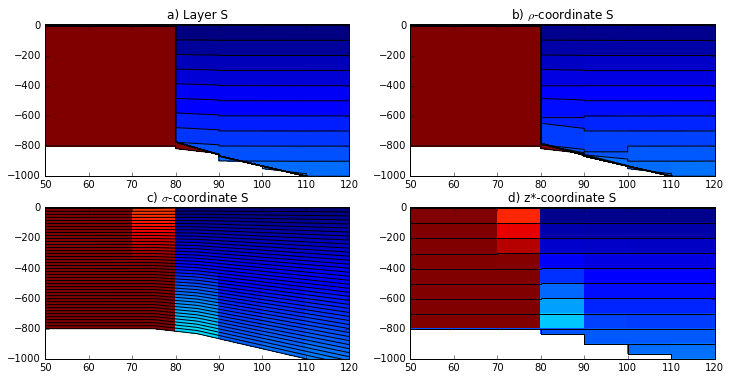

In [21]:
# Define a function to plot a section
def plot_section(file_handle, record, xq, variable='salt', clim=None, xl=None, yl=None,  plot_grid=True, rep='pcm'):
    """Plots a section by reading vertical grid and scalar variable and super-sampling
    both in order to plot vertical and horizontal reconstructions.
    
    Optional arguments have defaults for plotting salinity and overlaying the grid.
    """
    e = file_handle.variables['e'][record,:,0,:] # Vertical grid positions
    s = file_handle.variables[variable][record,:,0,:] # Scalar field to color
    x,z,q = m6toolbox.section2quadmesh(xq, e, s, representation=rep) # This yields three areas at twice the model resolution
    plt.pcolormesh(x, z, q);
    if clim is not None: plt.clim(clim)
    if plot_grid: plt.plot(x, z.T, 'k', hold=True);
    if xl is not None: plt.xlim(xl)
    if yl is not None: plt.ylim(yl)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1); plot_section(layer_file, 0, xq, xl=xxl, yl=yl, clim=(34,35), rep='plm'); plt.title('a) Layer S');
plt.subplot(2,2,2); plot_section(rho_file, 0, xq, xl=xxl, yl=yl, clim=(34,35), rep='plm'); plt.title(r'b) $\rho$-coordinate S');
plt.subplot(2,2,3); plot_section(sigma_file, 0, xq, xl=xxl, yl=yl, clim=(34,35), rep='linear'); plt.title(r'c) $\sigma$-coordinate S');
plt.subplot(2,2,4); plot_section(z_file, 0, xq, xl=xxl, yl=yl, clim=(34,35), rep='pcm'); plt.title('d) z*-coordinate S');